# Dogs vs Cats Redux from Scratch

## Imports, Constants and Settings

In [61]:
import os,sys
from shutil import copyfile
from PIL import Image
from keras.preprocessing import image

utils_path = os.path.abspath(os.path.join('./utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils import *

In [62]:
CURRENT_DIR = os.getcwd()
LESSON_HOME_DIR = CURRENT_DIR
DATA_HOME_DIR = CURRENT_DIR + '/data/redux'
TEST_PATH = DATA_HOME_DIR + '/test/' 
RESULTS_PATH = DATA_HOME_DIR + '/results/'


#PATH = DATA_HOME_DIR + '/sample/'
PATH = DATA_HOME_DIR + '/'

TRAIN_PATH = PATH + 'train/'
VALIDATION_PATH = PATH + 'validation/'

In [63]:
#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

## Helper Functions

In [64]:
def setup_standard_dir_structure():
    %cd $DATA_HOME_DIR
    %mkdir validation
    %mkdir results
    # Moving all test images to a class directory of 'unknown', to more easily work with batches
    %mkdir test/unknown
    %mkdir -p sample/train
    %mkdir -p sample/test
    %mkdir -p sample/validation
    %mkdir -p sample/results

# TODO: Make directory-agnostic
def count_images_in_training_set():
    %cd $DATA_HOME_DIR/train
    path, dirs, files = os.walk('.').next()
    return len(files)

# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def move_training_images_to_validation_set(percent):
    total_in_validation_set = int(total_images_in_training_set * (percent / 100.0))

    print('Moving {total} from training set to validation set.').format(total=str(total_in_validation_set))

    %cd $DATA_HOME_DIR/train
    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_validation_set):
        os.rename(shuffled_training_jpegs[i], DATA_HOME_DIR + '/validation/' + shuffled_training_jpegs[i])

# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def copy_training_images_to_sample(percent):
    total_in_sample_training_set = int(total_images_in_training_set * (percent / 100.0))

    print('Copying {total} from training set to sample training set.').format(total=str(total_in_sample_training_set))

    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_sample_training_set):
        copyfile(shuffled_training_jpegs[i], DATA_HOME_DIR + '/sample/train/' + shuffled_training_jpegs[i])
        
# TODO: Make directory-agnostic
# TODO: Factor out common stuff
def copy_validation_images_to_sample(percent):
    %cd $DATA_HOME_DIR/validation
    total_in_sample_validation_set = int(total_images_in_training_set * (percent / 100.0))

    print('Copying {total} from validation set to sample validation set.').format(total=str(total_in_sample_validation_set))

    all_training_jpegs = glob('*.jpg')
    shuffled_training_jpegs = np.random.permutation(all_training_jpegs)
    for i in range(total_in_sample_validation_set):
         copyfile(shuffled_training_jpegs[i], DATA_HOME_DIR + '/sample/validation/' + shuffled_training_jpegs[i])
           
def split_into_one_directory_per_class(dirs, classes):
    for dir in dirs:
        %cd $dir
        for categoryClass in classes:
            %mkdir {categoryClass}s
            %mv {categoryClass}.*.jpg {categoryClass}s/
            
def move_test_images_to_unknown_category_for_easier_batching():
    %cd $TEST_PATH
    %mv *.jpg unknown/
    
def plot_validated_images_by_index(indices, titles=None):
    plots([image.load_img(VALIDATION_PATH + validation_filenames[i]) for i in indices], titles=titles)

## Downloading Kaggle Data

Go ahead and run the following:

```
kg config -u farlion -p -c dogs-vs-cats-redux-kernels-edition
```


In [5]:
!kg download

Starting new HTTPS connection (1): www.kaggle.com
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

Starting new HTTPS connection (1): storage.googleapis.com
test.zip 100% |######################################| Time: 0:00:09  27.5 MiB/s
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |#####################################| Time: 0:00:17  30.9 MiB/s
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv already downloaded !


Now we're placing them into the following structure

```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

In [6]:
!unzip -q test.zip
!unzip -q train.zip

In [7]:
!rm test.zip train.zip

In [8]:
!mkdir -p data/redux
!mv test train data/redux/

## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create Validation and Sample sets

In [9]:
setup_standard_dir_structure()

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux


In [10]:
move_test_images_to_unknown_category_for_easier_batching()

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/test


In [11]:
total_images_in_training_set = count_images_in_training_set()
print('We have {total} images in total in our training set.').format(total=str(total_images_in_training_set))

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/train
We have 25000 images in total in our training set.


In [12]:
move_training_images_to_validation_set(percent=10)

Moving 2500 from training set to validation set.
/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/train


In [13]:
copy_training_images_to_sample(percent=1)

Copying 250 from training set to sample training set.


In [14]:
copy_validation_images_to_sample(percent=0.25)

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/validation
Copying 62 from validation set to sample validation set.


## Split up image files into class directories

In [15]:
dirs = ['{}/sample/train'.format(DATA_HOME_DIR), 
        '{}/sample/validation'.format(DATA_HOME_DIR),
        '{}/validation'.format(DATA_HOME_DIR),
        '{}/train'.format(DATA_HOME_DIR)]
classes = ['cat', 'dog']
split_into_one_directory_per_class(dirs=dirs, classes=classes)

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/sample/train
/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/sample/validation
/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/validation
/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/train


## Finetune and Train Model

In [65]:
%cd $DATA_HOME_DIR

vgg = Vgg16()

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux


In [66]:
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.01

In [67]:
train_batches = vgg.get_batches(TRAIN_PATH, batch_size=BATCH_SIZE)
validation_batches = vgg.get_batches(VALIDATION_PATH, batch_size=BATCH_SIZE)

vgg.finetune(train_batches)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [68]:
#Not sure if we set this for all fits
vgg.model.optimizer.lr = LEARNING_RATE

In [69]:
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(EPOCHS):
    print('Running epoch {}').format(epoch)
    vgg.fit(train_batches, validation_batches, nb_epoch=1)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    vgg.model.save_weights(RESULTS_PATH + latest_weights_filename)
print('Completed {} fit operations').format(EPOCHS)

Running epoch 0
Epoch 1/1
22500/22500 [==============================] - 604s - loss: 0.3809 - acc: 0.9680 - val_loss: 0.4061 - val_acc: 0.9704
Running epoch 1
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.3636 - acc: 0.9735 - val_loss: 0.3012 - val_acc: 0.9788
Running epoch 2
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.3187 - acc: 0.9774 - val_loss: 0.3908 - val_acc: 0.9736
Completed 3 fit operations


## Generate Predictions

In [70]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
prediction_batches, predictions = vgg.test(TEST_PATH, batch_size=BATCH_SIZE)

Found 12500 images belonging to 1 classes.


In [71]:
print(predictions[:5])

prediction_filenames = prediction_batches.filenames
print(prediction_filenames[:5])

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


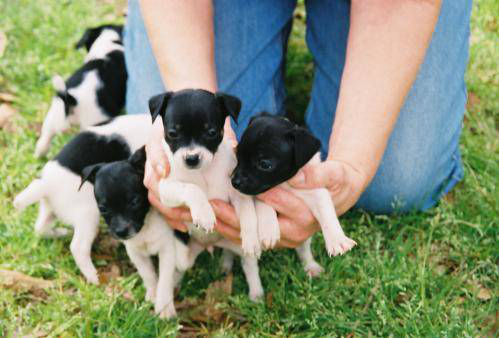

In [73]:
# You can verify the column ordering by viewing some images
Image.open(TEST_PATH + prediction_filenames[4])

In [74]:
#Save our test results arrays so we can use them again later
save_array(RESULTS_PATH + 'predictions.dat', predictions)
save_array(RESULTS_PATH + 'prediction_filenames.dat', prediction_filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [20]:
vgg.model.load_weights(RESULTS_PATH+latest_weights_filename)

In [75]:
validation_batches, validation_probabilities = vgg.test(VALIDATION_PATH, batch_size=BATCH_SIZE)
validation_filenames = validation_batches.filenames
expected_labels = validation_batches.classes # 0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = validation_probabilities[:,0]
our_labels = np.round(1-our_predictions)

Found 2500 images belonging to 2 classes.


In [76]:
NUMBER_OF_IMAGES_TO_VIEW = 4

Found 2436 correct labels


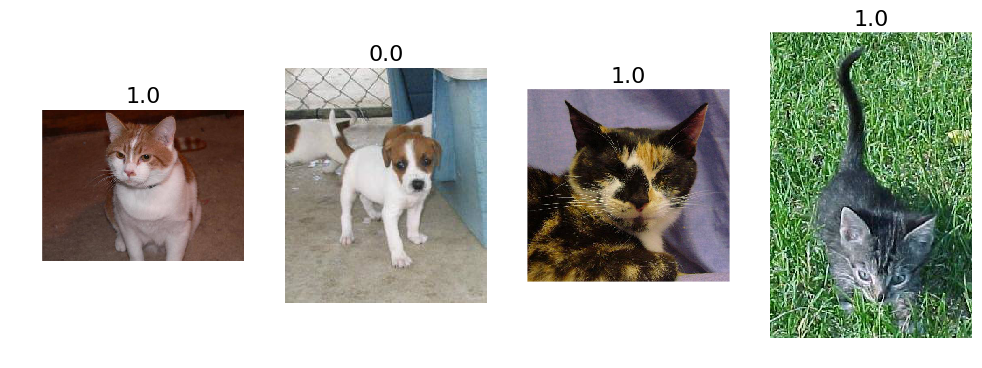

In [77]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print('Found {} correct labels'.format(len(correct)))
indices = permutation(correct)[:NUMBER_OF_IMAGES_TO_VIEW]
plot_validated_images_by_index(indices, our_predictions[indices])

Found 64 incorrect labels


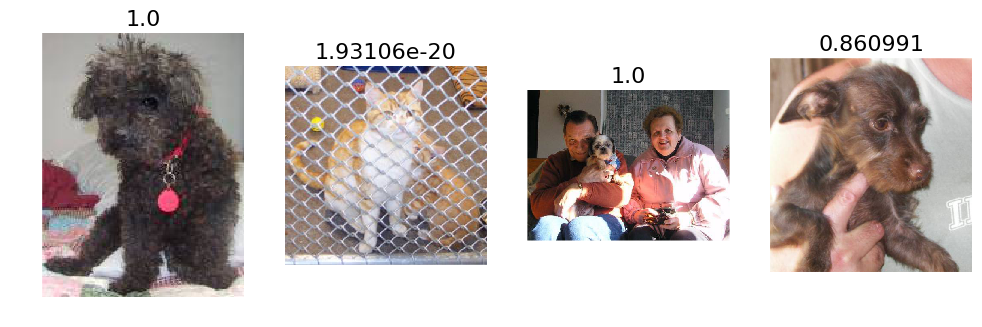

In [78]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print('Found {} incorrect labels'.format(len(incorrect)))
indices = permutation(incorrect)[:NUMBER_OF_IMAGES_TO_VIEW]
plot_validated_images_by_index(indices, our_predictions[indices])

Found 33 confident correct cats labels


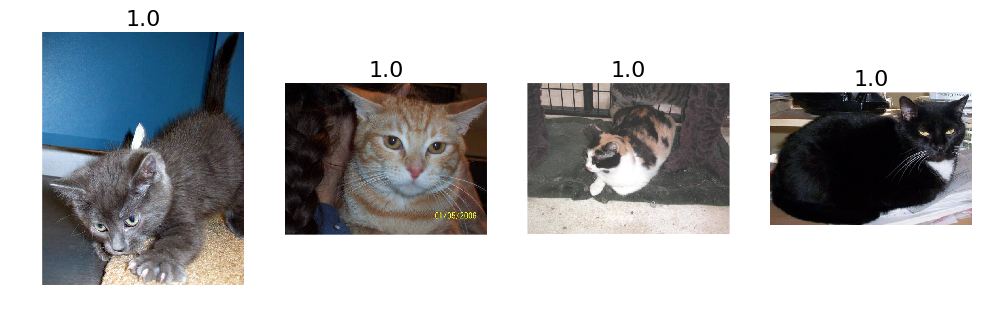

In [32]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print('Found {} confident correct cats labels').format(len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:NUMBER_OF_IMAGES_TO_VIEW]
plot_validated_images_by_index(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 29 confident correct dogs labels


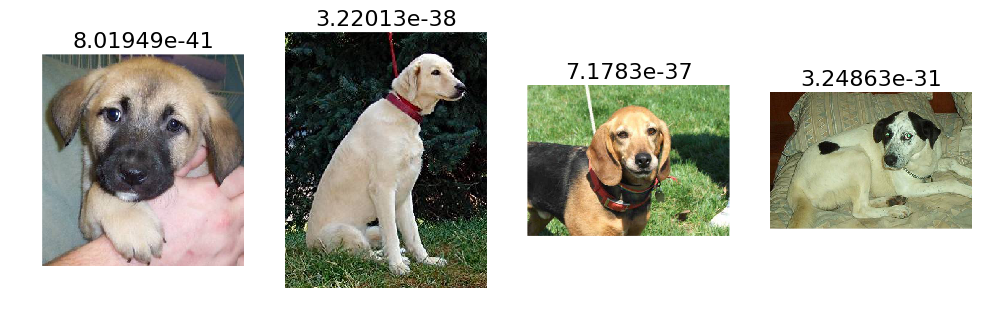

In [33]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:NUMBER_OF_IMAGES_TO_VIEW]
plot_validated_images_by_index(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 55 incorrect cats


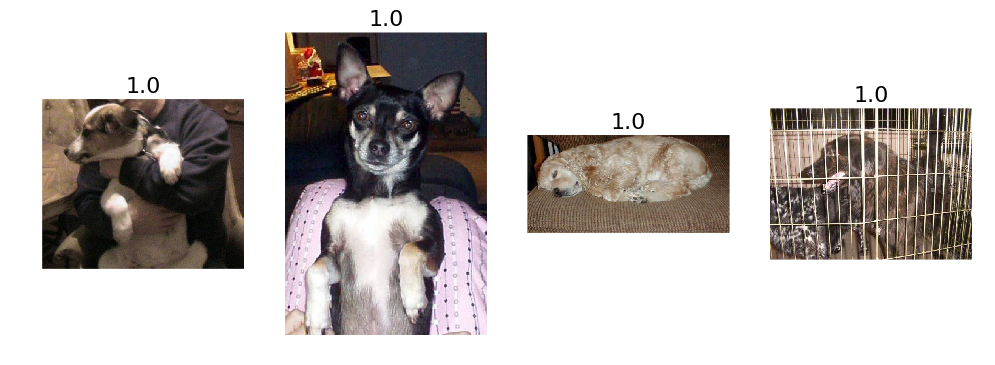

In [79]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:NUMBER_OF_IMAGES_TO_VIEW]
    plot_validated_images_by_index(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 9 incorrect dogs


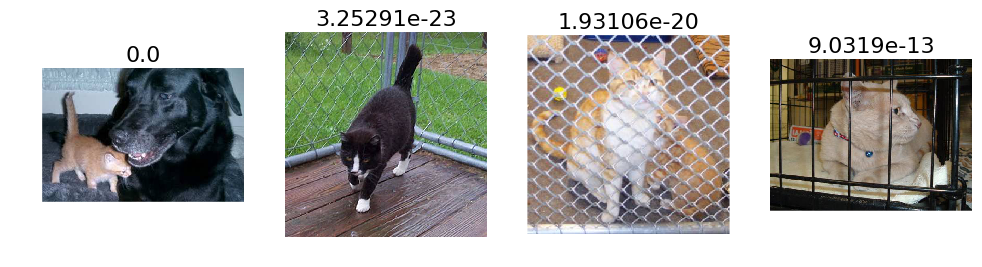

In [80]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:NUMBER_OF_IMAGES_TO_VIEW]
    plot_validated_images_by_index(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

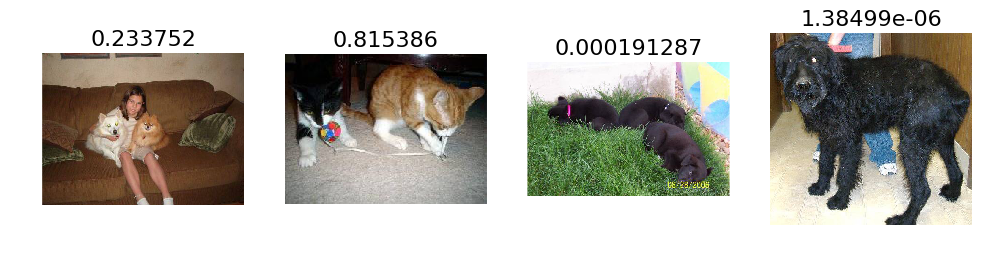

In [36]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plot_validated_images_by_index(most_uncertain[:NUMBER_OF_IMAGES_TO_VIEW], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [39]:
from sklearn.metrics import confusion_matrix as create_confusion_matrix
confusion_matrix = create_confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[33  0]
 [ 0 29]]


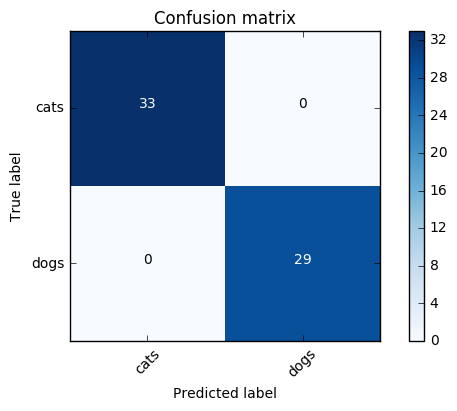

In [41]:
plot_confusion_matrix(confusion_matrix, validation_batches.class_indices)

## Submit Predictions to Kaggle

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [42]:
#Load our test predictions from file
predictions = load_array(RESULTS_PATH + 'predictions.dat')
prediction_filenames = load_array(RESULTS_PATH + 'prediction_filenames.dat')

In [48]:
#Grab the dog prediction column
is_dog = predictions[:,1]
print('Raw Predictions: {}'.format(str(is_dog[:5])))
print('Mid Predictions: {}'.format(str(is_dog[(is_dog < .6) & (is_dog > .4)])))
print('Edge Predictions: {}'.format(str(is_dog[(is_dog == 1) | (is_dog == 0)])))

Raw Predictions: [  4.5867e-32   2.2991e-02   7.1719e-20   2.4268e-40   1.0000e+00]
Mid Predictions: [ 0.4854  0.5179  0.5567  0.5709  0.4297  0.53    0.597   0.5983  0.4112  0.5716  0.5323  0.5451
  0.4573  0.4983  0.4892  0.554 ]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


In [49]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
is_dog = is_dog.clip(min=0.05, max=0.95)

In [56]:
#Extract imageIds from the filenames in our test/unknown directory 
submission_filenames = prediction_batches.filenames
submission_ids = np.array([int(f[8:f.find('.')]) for f in submission_filenames])
submission_ids

array([ 9292, 12026,  9688, ..., 11708,   525,  6375])

In [60]:
submission = np.stack([submission_ids, is_dog], axis=1)
submission.shape

(12500, 2)

In [52]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux


In [53]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)

/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch


/home/ubuntu/git/courses/deeplearning1/nbs/week-2-assignment/cats-dogs-redux-from-scratch/data/redux/submission1.csv